# 1. Tracking simple objects in videos

In [149]:
import cv2  
import numpy as np  
import matplotlib.pyplot as plt

In [150]:
video_path = 'video sequences/synthetic/escrime-4-3.avi'  # Chemin vers la vidéo
N = 300  # Nombre de particules
sigma = np.diag([50, 50])  # Bruit gaussien pour la prédiction (modèle de transition)
lambda_likelihood = 3  # Paramètre \lambda pour le calcul de la vraisemblance
hist_bins = 256  # Nombre de bins pour l'histogramme de couleurs

In [151]:
cap = cv2.VideoCapture(video_path)

In [152]:
ret, frame = cap.read()
if not ret:
    print("Erreur : Impossible de lire la vidéo")
else:
    # Sélectionner la zone à suivre manuellement
    roi = cv2.selectROI(frame)
    x, y, w, h = roi
    cv2.destroyAllWindows()

In [153]:
def calc_histogram(image, roi):
    x, y, w, h = roi
    roi_image = image[int(y):int(y+h), int(x):int(x+w)]
    hist = cv2.calcHist([roi_image], [0], None, [hist_bins], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Calculer l'histogramme de la région initiale
roi_hist = calc_histogram(frame, roi)

print(w,h,x,y)



35 36 304 222


[[333.61253689 240.50752726]
 [328.43391056 249.1136493 ]
 [334.22835756 226.07783781]
 [332.76300815 250.9931011 ]
 [315.18787405 241.4777454 ]
 [325.48265691 251.60439189]
 [304.94790261 232.62857455]
 [312.39530861 241.10767963]
 [335.25117741 255.33515288]
 [315.87549463 246.63562213]
 [316.35467057 247.67910914]
 [338.69448376 226.78589198]
 [317.2853538  242.36004434]
 [314.07594167 257.01321598]
 [337.55417288 251.21987312]
 [334.60285519 243.74263534]
 [337.07912618 232.14080036]
 [310.47556931 252.15743705]
 [325.38818069 242.52527512]
 [333.68003752 243.10440718]
 [328.18282251 238.31470602]
 [337.13122437 237.63509942]
 [315.99444312 236.39806754]
 [320.00685448 249.03116924]
 [336.5958342  238.01606129]
 [304.26683372 230.05304931]
 [331.28478802 256.47772076]
 [313.35591279 232.8876359 ]
 [338.66801619 253.53527253]
 [315.73268438 224.72625231]
 [335.66510258 246.11571098]
 [314.36289406 235.80581488]
 [337.8041825  231.81518966]
 [323.63380269 246.31170305]
 [332.45820853

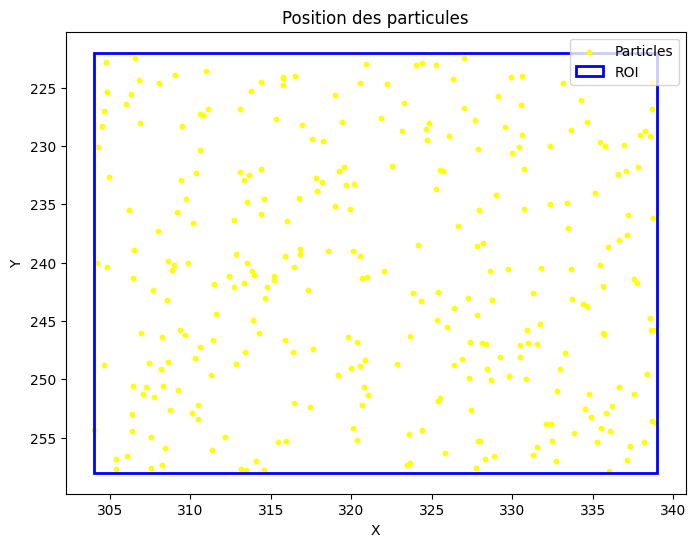

In [154]:
particles = np.column_stack((
    np.random.uniform(x, x + w, N),
    np.random.uniform(y, y + h, N)
))
weights = np.ones(N) / N  # Poids initiaux uniformes
print(particles)
import matplotlib.pyplot as plt

# Affichage des particules avec Matplotlib
def plot_particles(particles, x, y, w, h):
    plt.figure(figsize=(8, 6))
    plt.scatter(particles[:, 0], particles[:, 1], color='yellow', s=10, label="Particles")
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='blue', facecolor='none', linewidth=2, label="ROI"))
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Position des particules")
    plt.legend()
    plt.gca().invert_yaxis()  # Inverser l'axe Y pour correspondre aux coordonnées de l'image
    plt.show()

# Exemple d'utilisation pour afficher les particules
plot_particles(particles, x, y, w, h)

In [155]:
def predict(particles, sigma):
    noise = np.random.multivariate_normal([0, 0], sigma, N)
    particles += noise
    return particles

In [156]:
def compute_weights(particles, frame, roi_hist, lambd=lambda_likelihood):
    weights = np.zeros(N)
    for i, particle in enumerate(particles):
        px, py = particle
        # Définir une petite zone autour de chaque particule
        patch_hist = calc_histogram(frame, (px-w/2, py-h/2, w, h))

        # Calculer la distance entre les deux histogrammes 
        dist = cv2.compareHist(roi_hist, patch_hist, cv2.HISTCMP_BHATTACHARYYA)

        # Mettre à jour les poids selon la fonction de vraisemblance
        weights[i] = np.exp(-lambd * dist**2)

    # Normaliser les poids pour qu'ils forment une distribution de probabilité
    weights /= np.sum(weights)
    return weights

In [157]:
def resample(particles, weights):
    """
    Rééchantillonne les particules en fonction de leurs poids.
    
    Parameters:
    particles (numpy.ndarray): Les particules (positions) actuelles, de taille (N, 2).
    weights (numpy.ndarray): Les poids actuels des particules, de taille (N,).
    
    Returns:
    numpy.ndarray: Les nouvelles particules rééchantillonnées, de taille (N, 2).
    """
    N = len(particles)
    indices = np.arange(N)

    # Choisir des particules selon leurs poids en utilisant la méthode du rééchantillonnage systématique
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1.0  # Pour s'assurer que la somme est exactement 1
    u0 = np.random.uniform(0, 1/N)
    positions = (u0 + np.arange(N) / N)  # Échantillons également espacés

    # Indices des particules sélectionnées
    new_indices = np.searchsorted(cumulative_sum, positions)

    # Créer un nouvel ensemble de particules rééchantillonnées
    resampled_particles = particles[new_indices]

    return resampled_particles

What if we skip on frame for every two consecutive frames ?

In [158]:
frame_skip = 1  # Sauter une frame sur deux

In [159]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Initialisation de Matplotlib pour affichage en mode interactif
%matplotlib inline

# Initialisation de l'angle précédent
previous_angle = None

# Boucle principale avec frame_skip pour ignorer des frames
while True:
    for _ in range(frame_skip):  # Sauter des frames si nécessaire
        ret, frame = cap.read()
        if not ret:
            break 

    # Prédiction : mise à jour des particules avec du bruit
    particles = predict(particles, sigma)

    # Correction : calcul des poids à partir des histogrammes
    weights = compute_weights(particles, frame, roi_hist)

    # Rééchantillonnage : sélection des particules en fonction des poids
    particles = resample(particles, weights)

    # Calculer la position moyenne de l'objet après rééchantillonnage
    estimated_position = np.average(particles, axis=0, weights=weights)
    
    # Appliquer la PCA pour obtenir l'orientation de l'objet
    # Centrer les particules par rapport à leur moyenne
    centered_particles = particles - np.mean(particles, axis=0)
    
    # Calculer la matrice de covariance et obtenir les vecteurs propres (PCA)
    cov_matrix = np.cov(centered_particles, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Le vecteur propre correspondant à la plus grande valeur propre donne la direction principale
    principal_axis = eigenvectors[:, np.argmax(eigenvalues)]
    
    # Calculer l'angle d'orientation actuel en radians
    current_angle = np.arctan2(principal_axis[1], principal_axis[0])
    current_angle_degrees = np.degrees(current_angle)

    # Stabiliser l'orientation en utilisant l'angle précédent
    if previous_angle is not None:
        # Si la différence d'angle est supérieure à 90 degrés, ajuster pour éviter les basculements
        if abs(current_angle_degrees - previous_angle) > 90:
            current_angle_degrees += 180
            current_angle_degrees %= 360  # Garde l'angle dans la plage [0, 360]

    # Mettre à jour l'angle précédent pour la prochaine frame
    previous_angle = current_angle_degrees

    # Dessiner la direction de l’orientation sur l'image
    line_length = 50  # Longueur de la ligne pour indiquer l'orientation
    center_x, center_y = int(estimated_position[0]), int(estimated_position[1])
    end_x = int(center_x + line_length * principal_axis[0])
    end_y = int(center_y + line_length * principal_axis[1])

    # Afficher la ligne d'orientation sur l'image
    cv2.circle(frame, (center_x, center_y), 5, (0, 255, 0), -1)  # Centre de gravité en vert
    cv2.line(frame, (center_x, center_y), (end_x, end_y), (255, 0, 0), 2)  # Axe principal en bleu
    
     # Dessiner le rectangle autour de la position estimée
    #cv2.rectangle(frame,
                  #(int(estimated_position[0]-w/2), int(estimated_position[1]-h/2)),
                  #(int(estimated_position[0] + w/2), int(estimated_position[1] + h/2)),
                  #(0, 255, 0), 2)

    # Afficher chaque particule sur la vidéo avec un cercle bleu
    for particle in particles:
        cv2.circle(frame, (int(particle[0]), int(particle[1])), 2, (0, 255, 255), -1)  

    # Afficher l'image avec le suivi
    cv2.imshow("Tracking", frame)

    # Quitter en appuyant sur 'q'
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

# Libérer les ressources
cap.release()
cv2.destroyAllWindows()


TypeError: 'NoneType' object is not subscriptable

import numpy as np
import cv2
import matplotlib.pyplot as plt

# Initialisation de Matplotlib pour affichage en mode interactif
%matplotlib inline

# Initialisation de l'angle précédent
previous_angle = None

# Boucle principale avec frame_skip pour ignorer des frames
while True:
    for _ in range(frame_skip):  # Sauter des frames si nécessaire
        ret, frame = cap.read()
        if not ret:
            break

            # Prédiction : mise à jour des particules avec du bruit
    particles = predict(particles, sigma)

    # Correction : calcul des poids à partir des histogrammes
    weights = compute_weights(particles, frame, roi_hist)

    # Rééchantillonnage : sélection des particules en fonction des poids
    particles = resample(particles, weights)

    # Calculer la position moyenne de l'objet après rééchantillonnage
    estimated_position = np.average(particles, axis=0, weights=weights)

    # Appliquer la PCA pour obtenir l'orientation de l'objet
    centered_particles = particles - np.mean(particles, axis=0)
    cov_matrix = np.cov(centered_particles, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Axe principal d'orientation
    principal_axis = eigenvectors[:, np.argmax(eigenvalues)]
    
    # Calculer l'angle d'orientation actuel en radians
    current_angle = np.arctan2(principal_axis[1], principal_axis[0])
    current_angle_degrees = np.degrees(current_angle)

    # Stabiliser l'orientation en utilisant l'angle précédent
    if previous_angle is not None:
        # Si la différence d'angle est supérieure à 90 degrés, ajuster pour éviter les basculements
        if abs(current_angle_degrees - previous_angle) > 90:
            current_angle_degrees += 180
            current_angle_degrees %= 360  # Garde l'angle dans la plage [0, 360]

    # Mettre à jour l'angle précédent pour la prochaine frame
    previous_angle = current_angle_degrees

    # Dessiner la direction de l’orientation sur l'image
    line_length = 50
    center_x, center_y = int(estimated_position[0]), int(estimated_position[1])
    end_x = int(center_x + line_length * principal_axis[0])
    end_y = int(center_y + line_length * principal_axis[1])

    # Visualiser avec Matplotlib
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    #plt.scatter(particles[:, 0], particles[:, 1], color='yellow', s=10, label="Particles")
    plt.plot([center_x, end_x], [center_y, end_y], color="blue", linewidth=2, label="Orientation")
    plt.scatter(center_x, center_y, color="green", s=50, label="Center")
    plt.legend()
    plt.axis('off')  # Masquer les axes
    plt.show()

    # Pause pour simuler le suivi image par image
    plt.pause(0.1)
    plt.clf()  # Nettoyer la figure pour la prochaine image

# Libérer les ressources
cap.release()
plt.close()